In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from data.metrics import recall
from visualization.plot_utils import write_latex_table, summary_pooling_table, pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features.tracks_info import TrackInfo
from collections import OrderedDict
from itertools import product
from data_utils import product_size
import matplotlib.pyplot as plt
import seaborn as sns

def pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    r_t = recall(true_t, pool_t)
    r_a = recall(true_a, pool_a)
    return OrderedDict([('pid',pid),('k',k),('strat',strat),('n',n_pick),('recall_tracks',r_t),('recall_artist',r_a)])

plot_settings()
pandas_settings()

# create pooling model

In [3]:
from models.word2vec_pooler import W2VPooler

pooler =  W2VPooler(verbose=True)
tracks = TrackInfo(subset='5k-')
list_s = [('The Scientist','Coldplay'),('Immigrant Song','Led Zeppelin'),('T.N.T.','AC/DC')]
from sklearn.cluster import k_means
seeds_t = [tracks.track_info2uris(tname,aname)[0] for tname,aname in list_s]
pool, dist= pooler.recommend(seeds_t,n=500,agg_strat='mean')

FileNotFoundError: [Errno 2] No such file or directory: '../data/pooling/model_min5_new.bin'

# test over metrics
## one playlist

In [4]:
k=25
pid = 1945
n_pick = 100
strat='medoids' # there are many sampling strategies
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
display(pd.DataFrame([pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a)]))

Found 25 out of 25 vecs
4-medoids , returning pool of size 100


,pid,k,strat,n,recall_tracks,recall_artist
0,1945,25,medoids,100,0.08,0.13


## how large does n have to be?

In [5]:
k=25
pid = 194
n_pick = 100000
strat='medoids'
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
# acrue results for k
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_pick,2500))
stats=[]
for i in pool_range:
    stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
stats_df = pd.DataFrame(stats)
stats_df.head()

Found 25 out of 25 vecs
4-medoids , returning pool of size 100000


,pid,k,strat,n,recall_tracks,recall_artist
0,194,25,medoids,25,0.05,0.03
1,194,25,medoids,125,0.10,0.10
2,194,25,medoids,225,0.11,0.11
3,194,25,medoids,325,0.11,0.12
4,194,25,medoids,425,0.12,0.16


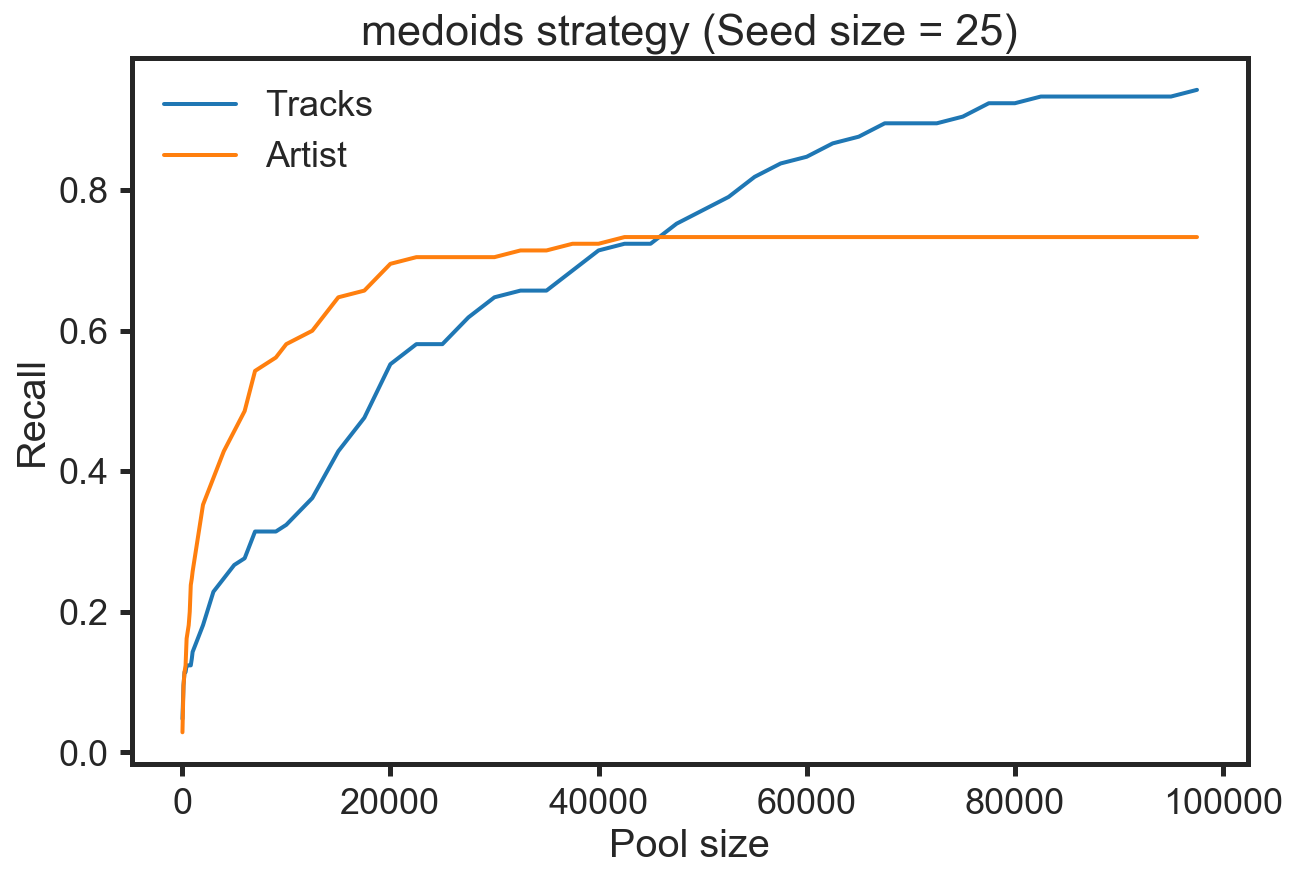

In [6]:
import matplotlib.pyplot as plt
plt.plot(stats_df['n'],stats_df['recall_tracks'],label='Tracks')
plt.plot(stats_df['n'],stats_df['recall_artist'],label='Artist')
plt.ylabel('Recall')
plt.xlabel('Pool size')
plt.title('{} strategy (Seed size = {})'.format(strat,k))
plt.legend()
plt.show()

# several random playlists

In [87]:
pooler.verbose=False
ks = [5, 10, 25, 100]
stats=[]
pids = [i for i in np.random.randint(0,5000,250)]
n_picks = [1000]
strats=['mean','centroids','medoids','split']
product_n = product_size([ks,pids,n_picks,strats])
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            stats.append(pool_stats(pid,k,strat,i,true_t,pool_t,true_a,pool_a))
    except ValueError as e:
        print('Error with {}'.format(combo))


  9%|▊         | 256/3000 [00:12<02:17, 19.94it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

  9%|▊         | 262/3000 [00:12<02:15, 20.18it/s]

Error with ('mean', 1000, 653, 5)



 35%|███▌      | 1062/3000 [01:16<02:19, 13.93it/s]


 42%|████▏     | 1256/3000 [02:37<03:38,  7.97it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/beangoben/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:314: RuntimeWarning: Mean of empty slice.
  X_mean = X.mean(axis=0)


Error with ('centroids', 1000, 653, 5)



 55%|█████▌    | 1656/3000 [05:30<04:28,  5.01it/s]


 67%|██████▋   | 2023/3000 [08:09<03:56,  4.13it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)

 68%|██████▊   | 2050/3000 [08:20<03:52,  4.09it/s]


 75%|███████▌  | 2256/3000 [09:46<03:13,  3.85it/s]

Error with ('medoids', 1000, 653, 5)



 89%|████████▊ | 2656/3000 [12:36<01:37,  3.51it/s]


100%|██████████| 3000/3000 [15:04<00:00,  3.32it/s]


## Results

/home/beangoben/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


pid       r-tracks       r-artist
                   count     mean (std)     mean (std)
k   strategy  n                                       
5   centroids 1000   249  0.348 (0.225)  0.388 (0.195)
    mean      1000   249  0.384 (0.251)  0.411 (0.214)
    medoids   1000   249  0.348 (0.225)  0.388 (0.195)
10  centroids 1000   240  0.355 (0.246)  0.393 (0.214)
    mean      1000   240  0.392 (0.270)  0.424 (0.228)
    medoids   1000   240  0.355 (0.246)  0.393 (0.214)
25  centroids 1000   189  0.366 (0.233)  0.412 (0.225)
    mean      1000   189  0.356 (0.243)  0.423 (0.233)
    medoids   1000   189  0.323 (0.226)  0.395 (0.230)
100 centroids 1000    62  0.314 (0.196)  0.370 (0.165)
    mean      1000    62  0.325 (0.227)  0.373 (0.197)
    medoids   1000    62  0.255 (0.176)  0.348 (0.164)

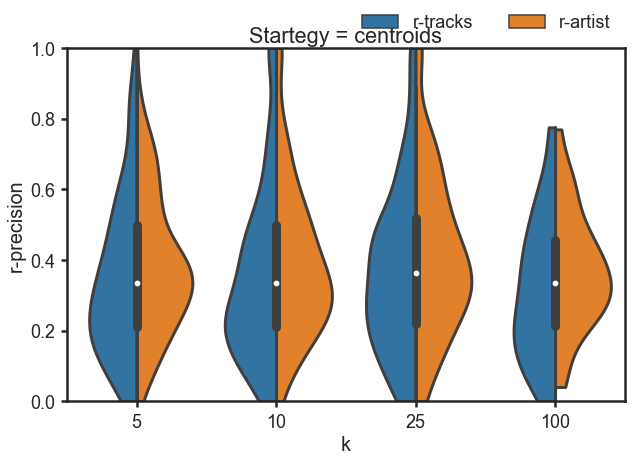

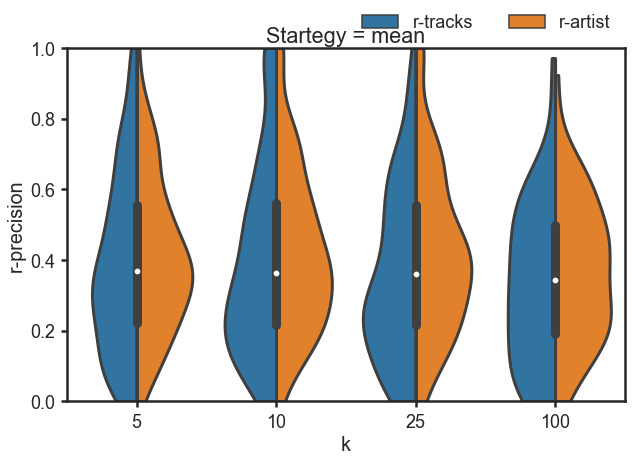

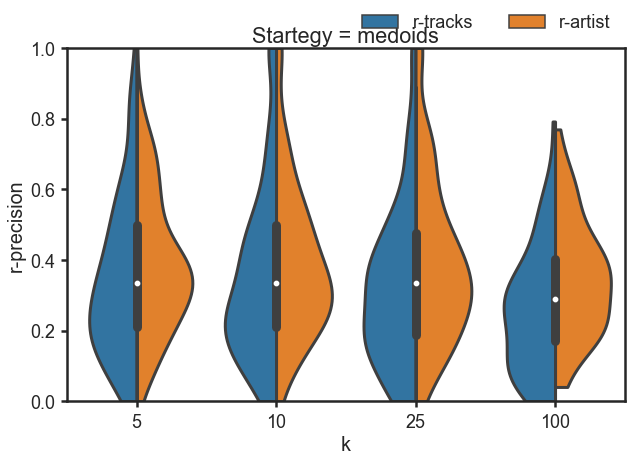

/home/beangoben/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


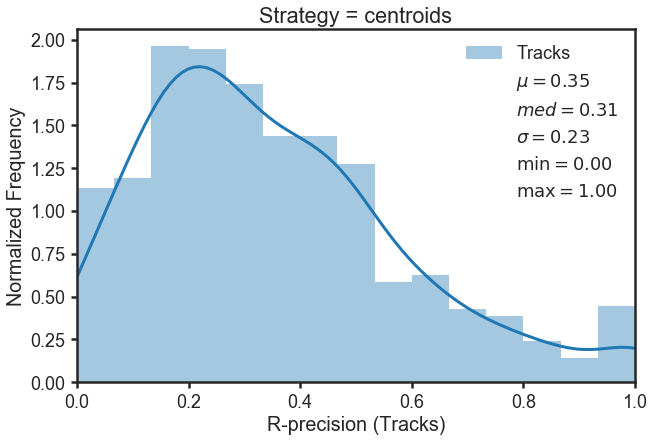

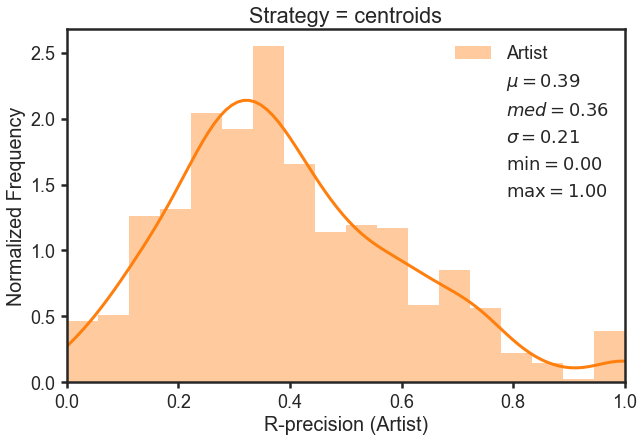

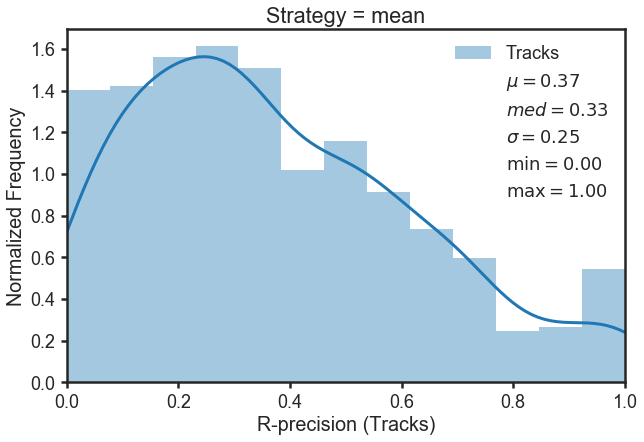

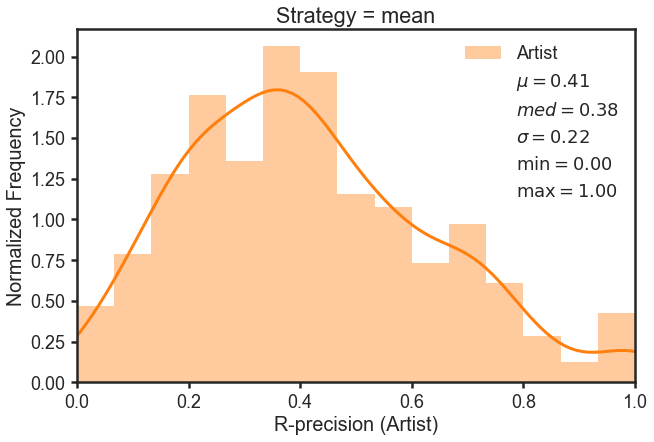

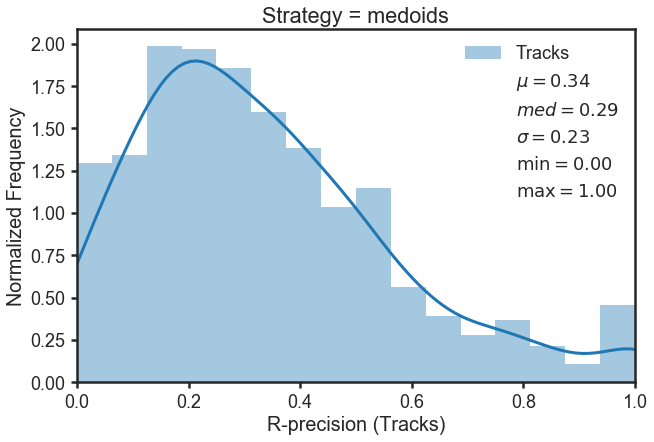

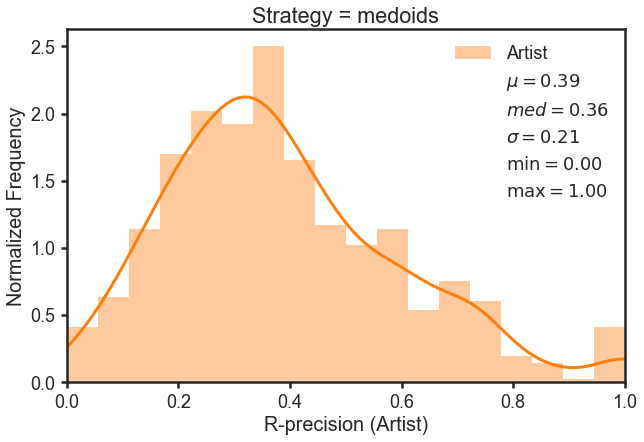

In [90]:
summ_df = summary_pooling_table(stats)
#write_latex_table(summ_df,'pooling')
display(summ_df)
pooling_plots(stats)

# How big of a pool do we need (on average)?

In [14]:
pooler.verbose=False
ks = [100]
stats=[]
pids = [i for i in np.random.randint(0,5000,100)]
n_picks = [25000]
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_picks[0],2500))
strats=['mean','centroids','medoids','wcentroids','wmedoids','split']
product_n = product_size([strats,n_picks,pids,ks])
stats=[]
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            for i in pool_range:
                stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
    except ValueError as e:
        print('Error with {}'.format(combo))
# random test
for combo in product(*[pids,ks]):
    pid,k = combo
    pl_turi,pl_auri = tracks.get_playlist(pid)
    if len(pl_turi) > k:
        seeds_t = pl_turi[:k]
        true_t,true_a = pl_turi[k:],pl_auri[k:]
        for i in pool_range:
            pool_t,pool_a = tracks.random_tracks(i,exclude=seeds_t)
            stats.append(pool_stats(pid,k,'random',i,true_t,pool_t,true_a,pool_a))

stats_df = pd.DataFrame(stats)
stats_df.head()

 33%|███▎      | 200/600 [00:16<00:33, 11.87it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
100%|██████████| 600/600 [03:49<00:00,  2.62it/s]


,pid,k,strat,n,recall_tracks,recall_artist
0,338,100,mean,25,0.00,0.00
1,338,100,mean,125,0.06,0.33
2,338,100,mean,225,0.17,0.56
3,338,100,mean,325,0.22,0.67
4,338,100,mean,425,0.33,0.72


## results

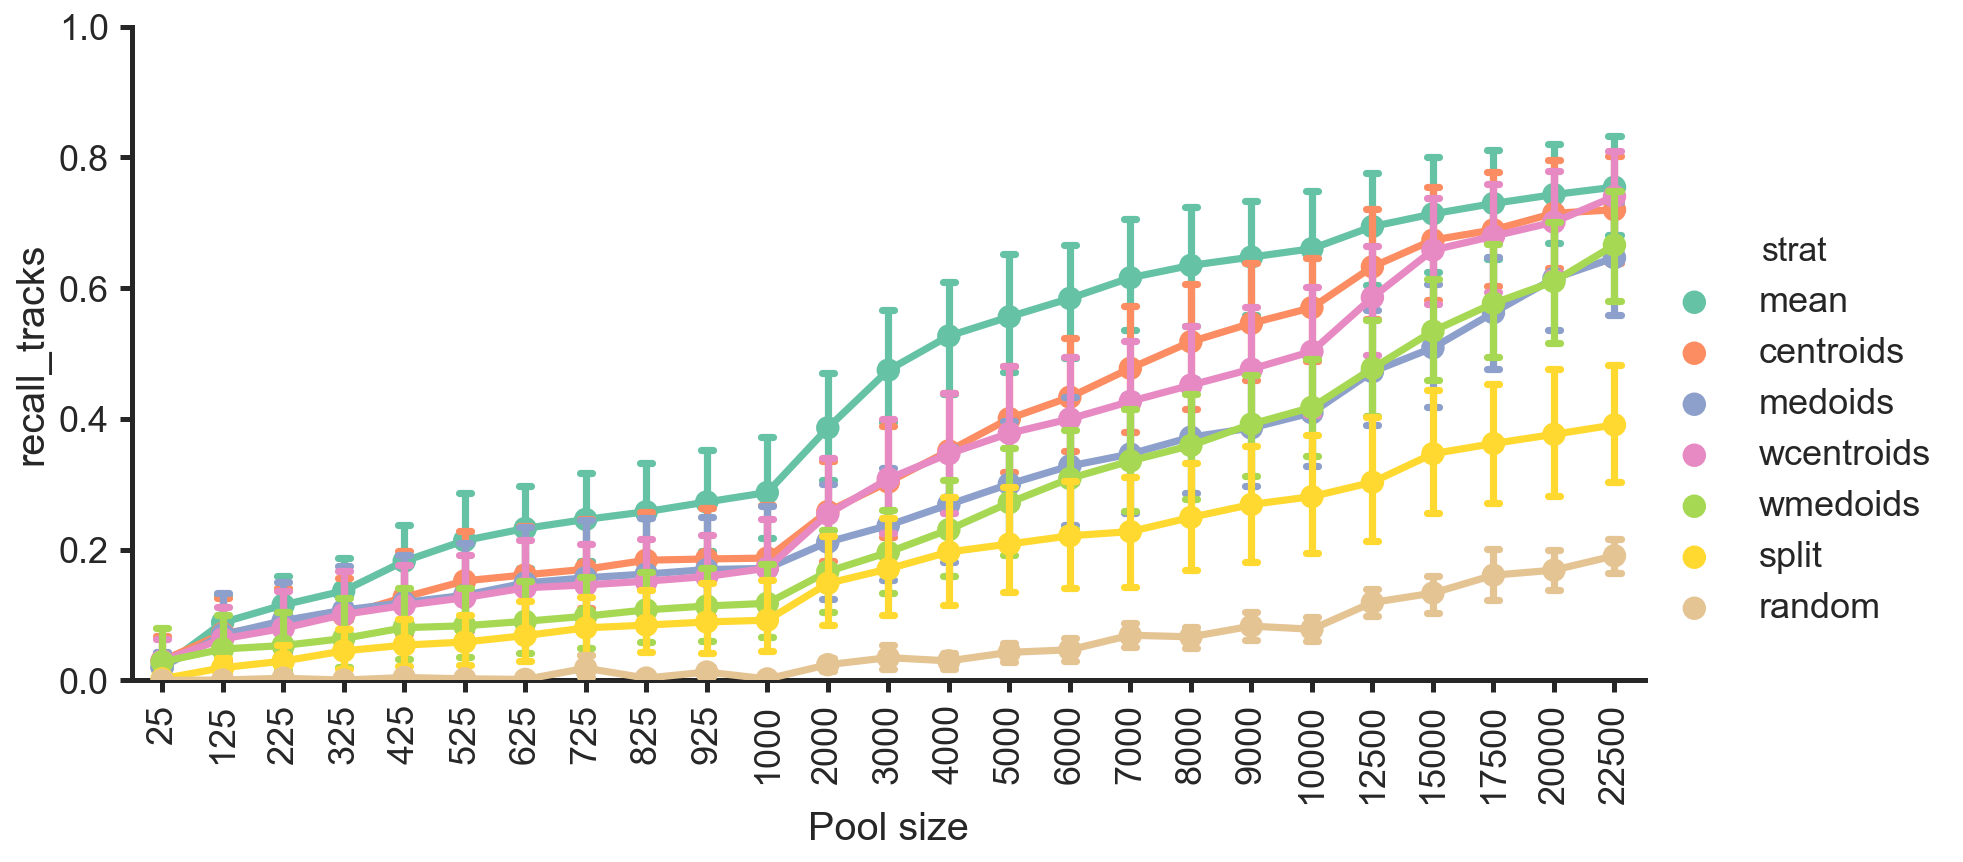

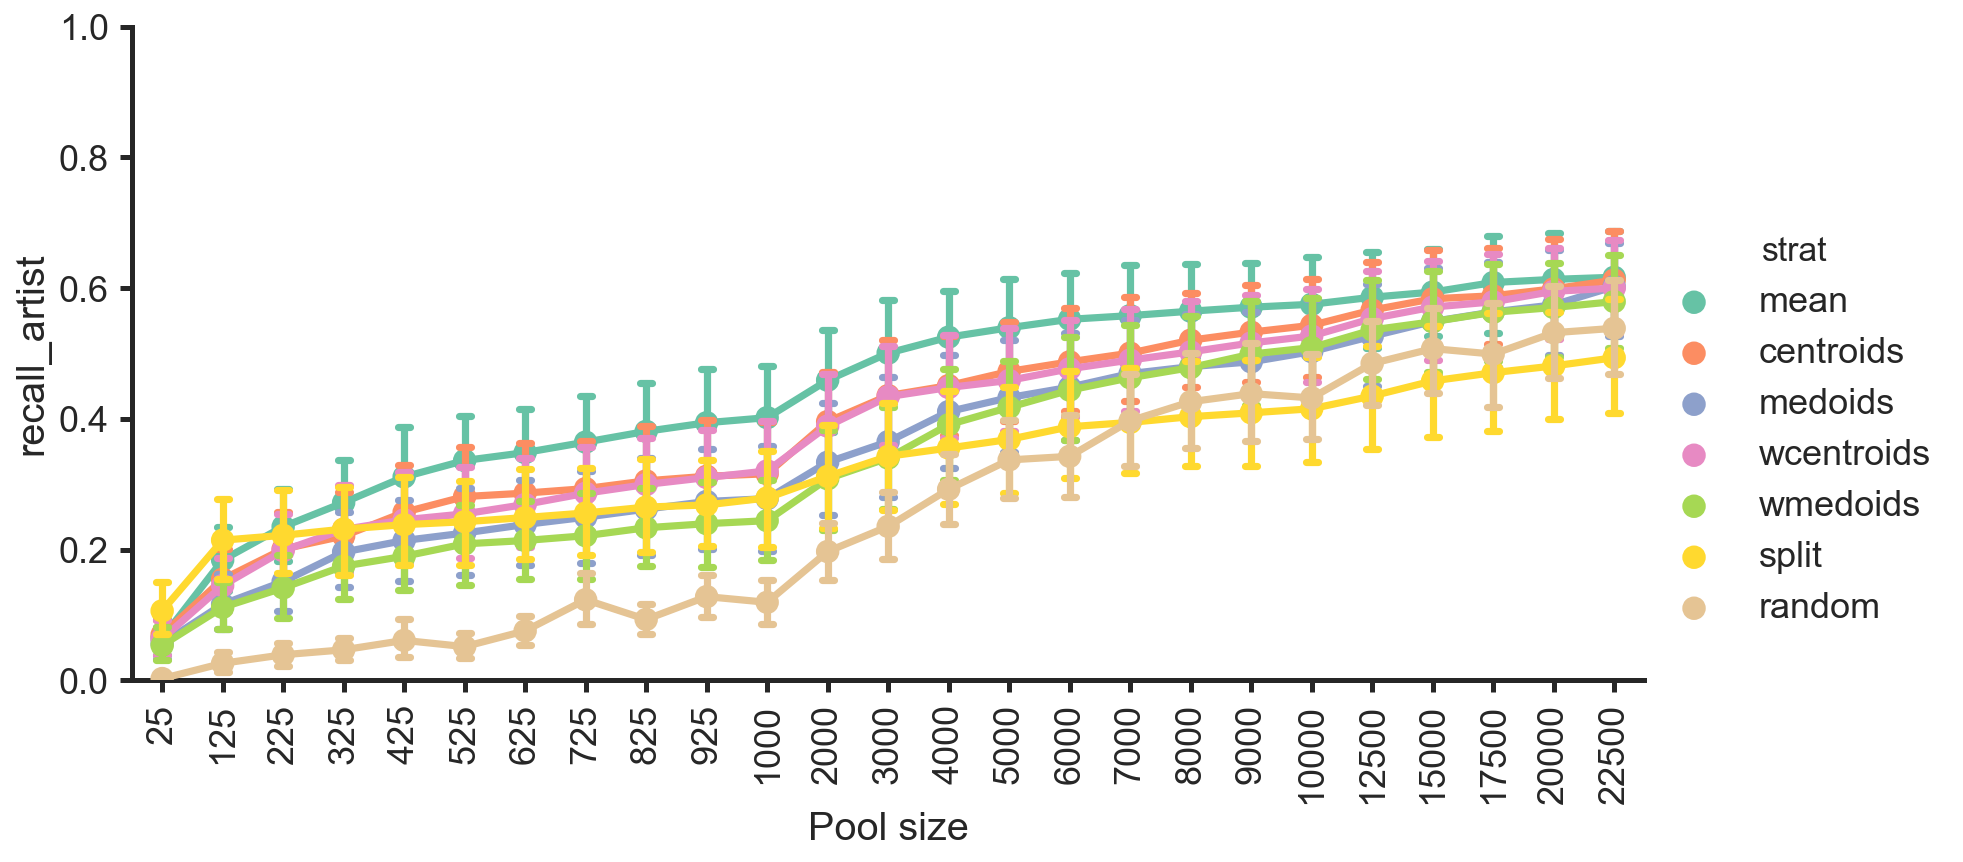

In [15]:
sns.factorplot(x="n", y="recall_tracks", hue="strat", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Track)')
plt.xlabel('Pool size')
plt.show()
sns.factorplot(x="n", y="recall_artist", hue="strat", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2,alpha=0.75)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Artist)')
plt.xlabel('Pool size')
plt.show()